## This note is used to show training in RFDiffusion


In [3]:
# sample a structure from PDB
import requests
import os

def fetch_pdb(pdb_id, save_dir="pdb_files"):
    """
    Fetches a PDB file from the RCSB Protein Data Bank and saves it locally.
    
    Args:
        pdb_id (str): The PDB ID of the structure to fetch (e.g., "1HHO").
        save_dir (str): Directory to save the PDB file. Default is 'pdb_files'.
        
    Returns:
        str: Path to the saved PDB file, or None if download failed.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Construct the URL for the PDB file
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    save_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    
    try:
        # Download the PDB file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        # Write the file to the save directory
        with open(save_path, "wb") as pdb_file:
            for chunk in response.iter_content(chunk_size=1024):
                pdb_file.write(chunk)
        
        print(f"PDB file {pdb_id} successfully downloaded to {save_path}")
        return save_path
    except requests.exceptions.RequestException as e:
        print(f"Failed to download PDB file {pdb_id}: {e}")
        return None

# Example usage:
pdb_id = "1UBQ"  # Replace with your desired PDB ID
fetch_pdb(pdb_id)


PDB file 1UBQ successfully downloaded to pdb_files/1UBQ.pdb


'pdb_files/1UBQ.pdb'

In [1]:
# convert pdb to numpy
import numpy as np
import torch

def pdb_to_xyz_n_ca_c(pdb_file):
    """
    Extracts and groups N, CA, and C atom coordinates by residue from a PDB file.
    
    Args:
        pdb_file (str): Path to the PDB file.
        
    Returns:
        np.ndarray: Array of shape (num_residues, 3, 3) with coordinates for N, CA, C atoms.
    """
    from collections import defaultdict

    # Map of (chain_id, res_seq) → {'N': [...], 'CA': [...], 'C': [...]}
    residues = defaultdict(dict)

    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_name = line[12:16].strip()
                if atom_name in {"N", "CA", "C"}:
                    chain_id = line[21].strip()
                    res_seq = int(line[22:26].strip())  # Residue index
                    res_key = (chain_id, res_seq)

                    x = float(line[30:38].strip())
                    y = float(line[38:46].strip())
                    z = float(line[46:54].strip())

                    residues[res_key][atom_name] = [x, y, z]

    # Collect residues that have all three atoms
    grouped_coords = []
    for res in sorted(residues.keys()):
        atom_dict = residues[res]
        if all(name in atom_dict for name in ("N", "CA", "C")):
            grouped_coords.append([
                atom_dict["N"],
                atom_dict["CA"],
                atom_dict["C"]
            ])

    return np.array(grouped_coords)  # shape: (num_residues, 3, 3)


# Example usage:
pdb_file_path = 'pdb_files/1UBQ.pdb'  # Replace with the path to your PDB file
arr = pdb_to_xyz_n_ca_c(pdb_file_path)

# Reshaping the array to shape (n, 3, 3)
xyz = torch.tensor(arr)


# Print or save the resulting XYZ array
print("XYZ Array Shape:", xyz.shape)
#print(xyz_array)



XYZ Array Shape: torch.Size([76, 3, 3])


In [2]:
import sys
sys.path.append('/home/yunyao/RFdiffusion/rfdiffusion')

from util import rigid_from_3_points

In [3]:
import torch

def extract_r_z(xyz: torch.Tensor):
    """
    Extract rotation matrix (R_true), centered coordinates (Ca_true),
    and transformed coordinates (z) from input 3D structure.
    
    Args:
        xyz (torch.Tensor): Input coordinates [num_residues, num_atoms, 3].
        
    Returns:
        R_true (torch.Tensor): Rotation matrix.
        Ca_true (torch.Tensor): Centered coordinates of the alpha carbons.
        z (torch.Tensor): Transformed coordinates.
    """
    # Center protein coordinates at origin
    xyz_centered = xyz - torch.mean(xyz[:, 1, :], dim=0, keepdim=True)
    
    # Extract N, Ca, and C atom positions
    N = xyz_centered[None,:, 0, :]  # Backbone nitrogen
    Ca = xyz_centered[None, :, 1, :]  # Alpha carbon
    C = xyz_centered[None, :, 2, :]  # Carbonyl carbon
    
    # Apply a rigid body transformation
    R_true, Ca_true = rigid_from_3_points(N, Ca, C)  # Replace with your implementation
    
    # Adjust coordinates using the transformation
    diff = Ca - Ca_true  # Shift to align Ca positions
    z = xyz_centered - diff[:,:, None, :]
    
    return R_true[0], Ca_true[0], z[0]
R_true, Ca, xyz = extract_r_z(xyz)
print(R_true.shape, Ca.shape, xyz.shape)

torch.Size([76, 3, 3]) torch.Size([76, 3]) torch.Size([76, 3, 3])


In [4]:
from diffusion import IGSO3

T=200
min_sigma=0
max_sigma=1
min_b=0
max_b=1
cache_dir='./cache'

# rotation noise linear schedulear sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)
# sigma_min = 0.02, beta_min =1.06  beta_max=1.77
# rotation noise log schedular  log(sigma(t))= logsigma_min + t/T * (log(sigma_max)-log(sigma_min))

# in the SI, it seems the linear one is used and max_sigma is not used
test = IGSO3(T=T,
        min_sigma=0.02,
        max_sigma=1,
        min_b=1.06,
        max_b=1.77,
        cache_dir=cache_dir,
        num_omega=1000,
        schedule="linear",
        L=2000)

In [5]:
# now visulaization  rotatio noise schedule
print(test.igso3_vals['cdf'].shape)  #(num_sigma,  num_omega)
#test.igso3_vals.keys()
#test.igso3_vals['discrete_sigma'].shape
#test.igso3_vals['discrete_omega'].shape


(500, 1000)


### Alert
Discrete_sigma is different from sigma(t) = sigma_min + (t)*beta_min + 1/2(t)^2(beta_max-beta_min); t ~(0,1) = ts/T  
given ts we get t, and according sigma value based on sigma(t), then we got idx in discrete_sigma for the sigma value  
the idx is finally use to fetch pdf cdf score for according sigma value  

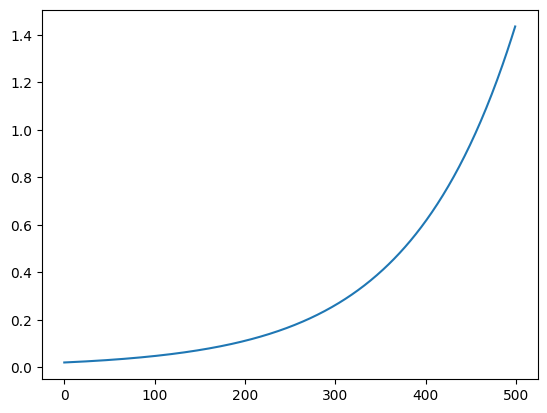

In [6]:
test.discrete_sigma
import matplotlib.pyplot as plt
plt.plot(test.discrete_sigma)  # this is the sigma used to generate grids to calculate pdf cdf and score



In [9]:
# g(t)= d/dt( sigma(t)^2)
test.g(0.4)

tensor(1.1602)

In [7]:
# import the translation diffuser
from diffusion import EuclideanDiffuser
# translation noise schedular beta(t) = beta_min + (beta_max-beta_min)*t/T
# in the paper beta_max=0.07, beta_min=0.01
trans_test=EuclideanDiffuser(T=T,
        b_0=0.01,
        b_T=0.07,
        schedule_type="linear")

In [8]:
# now perturb the structure one translation one rotation
diffused_T, deltas = trans_test.diffuse_translations(
            torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None
        )
print(diffused_T.shape)
print(deltas.shape) # ca cooridnate difference


torch.Size([76, 200, 3, 3])
torch.Size([76, 200, 3])


/tmp/ipykernel_1689415/451908041.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None


In [9]:
diffused_frame_crds, diffused_frames = test.diffuse_frames(
           torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None, t_list=None
        )

/tmp/ipykernel_1689415/1733559996.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None, t_list=None


In [13]:
print(diffused_frame_crds.shape)

(76, 200, 3, 3)


NCA avg: 1.4733696107286516 std: 0.016948937934009405
CAC  avg: 1.5215819483790822 std: 0.01567240782129439
NCA avg: 1.4733696107286511 std: 0.016948937934009433
CAC  avg: 1.5215819483790818 std: 0.015672407821294365
NCA avg: 1.4733696107286514 std: 0.016948937934009416
CAC  avg: 1.5215819483790818 std: 0.01567240782129439
NCA avg: 1.4733696107286511 std: 0.01694893793400943
CAC  avg: 1.521581948379082 std: 0.015672407821294383
NCA avg: 1.4733696107286514 std: 0.016948937934009464
CAC  avg: 1.521581948379082 std: 0.015672407821294407


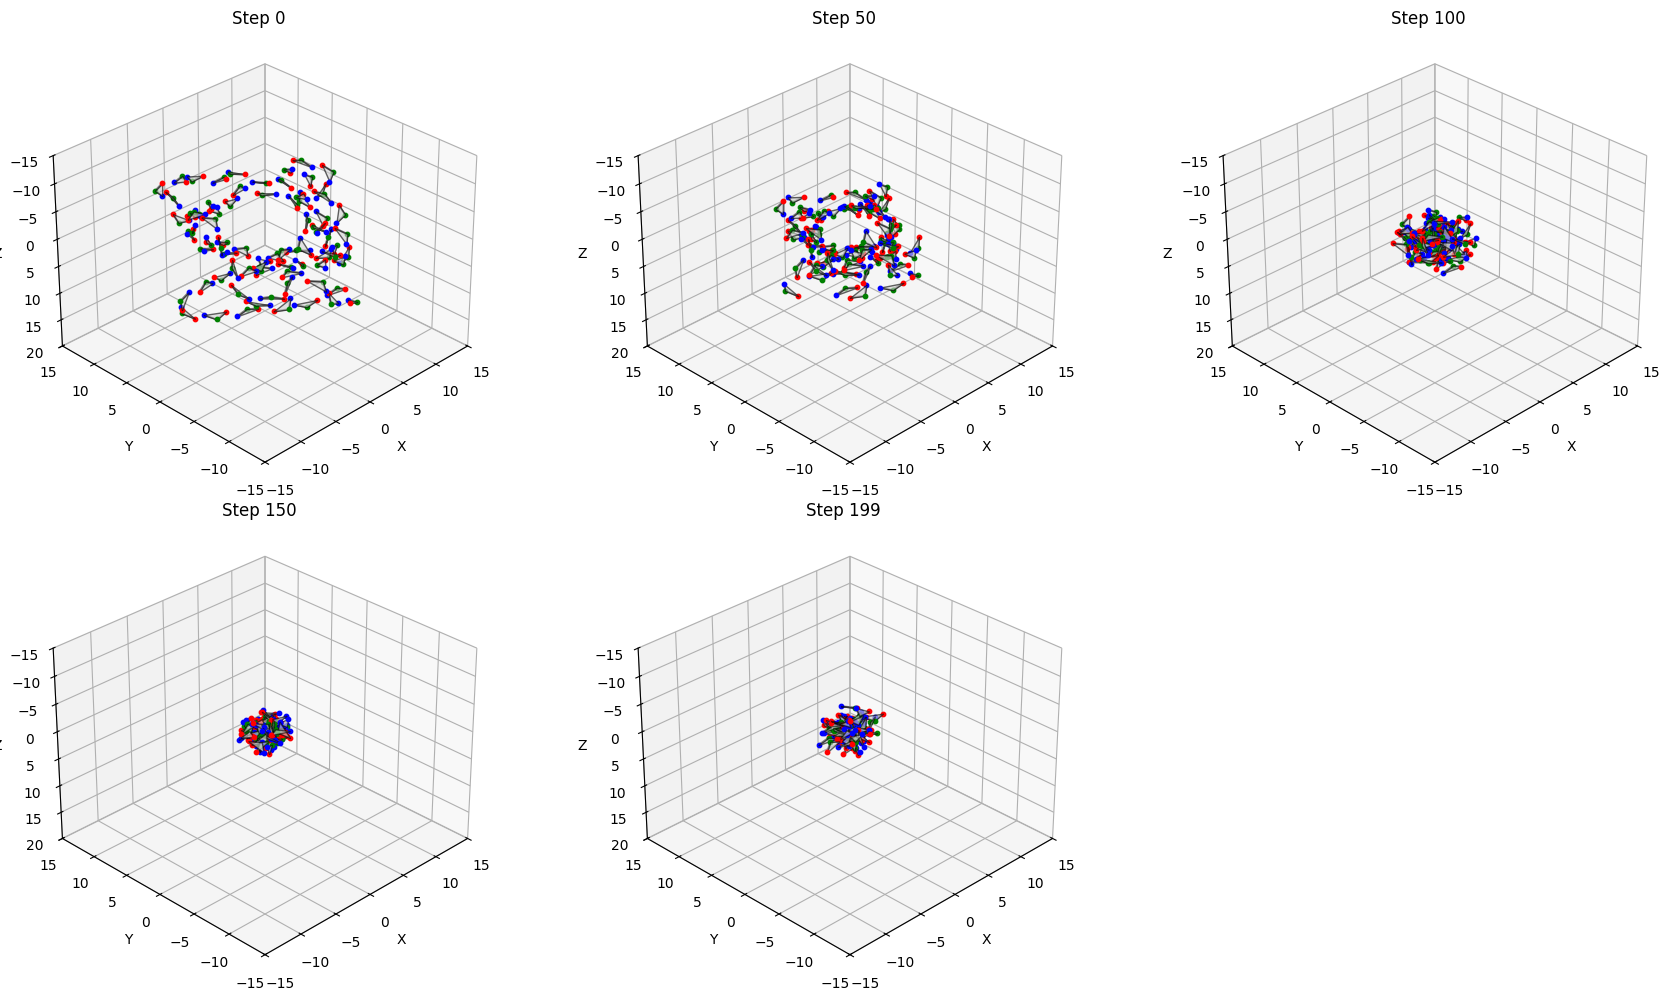

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))



for i, step_index in enumerate(step_indexes):
    coords = diffused_T[:, step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = diffused_T.shape[0]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()



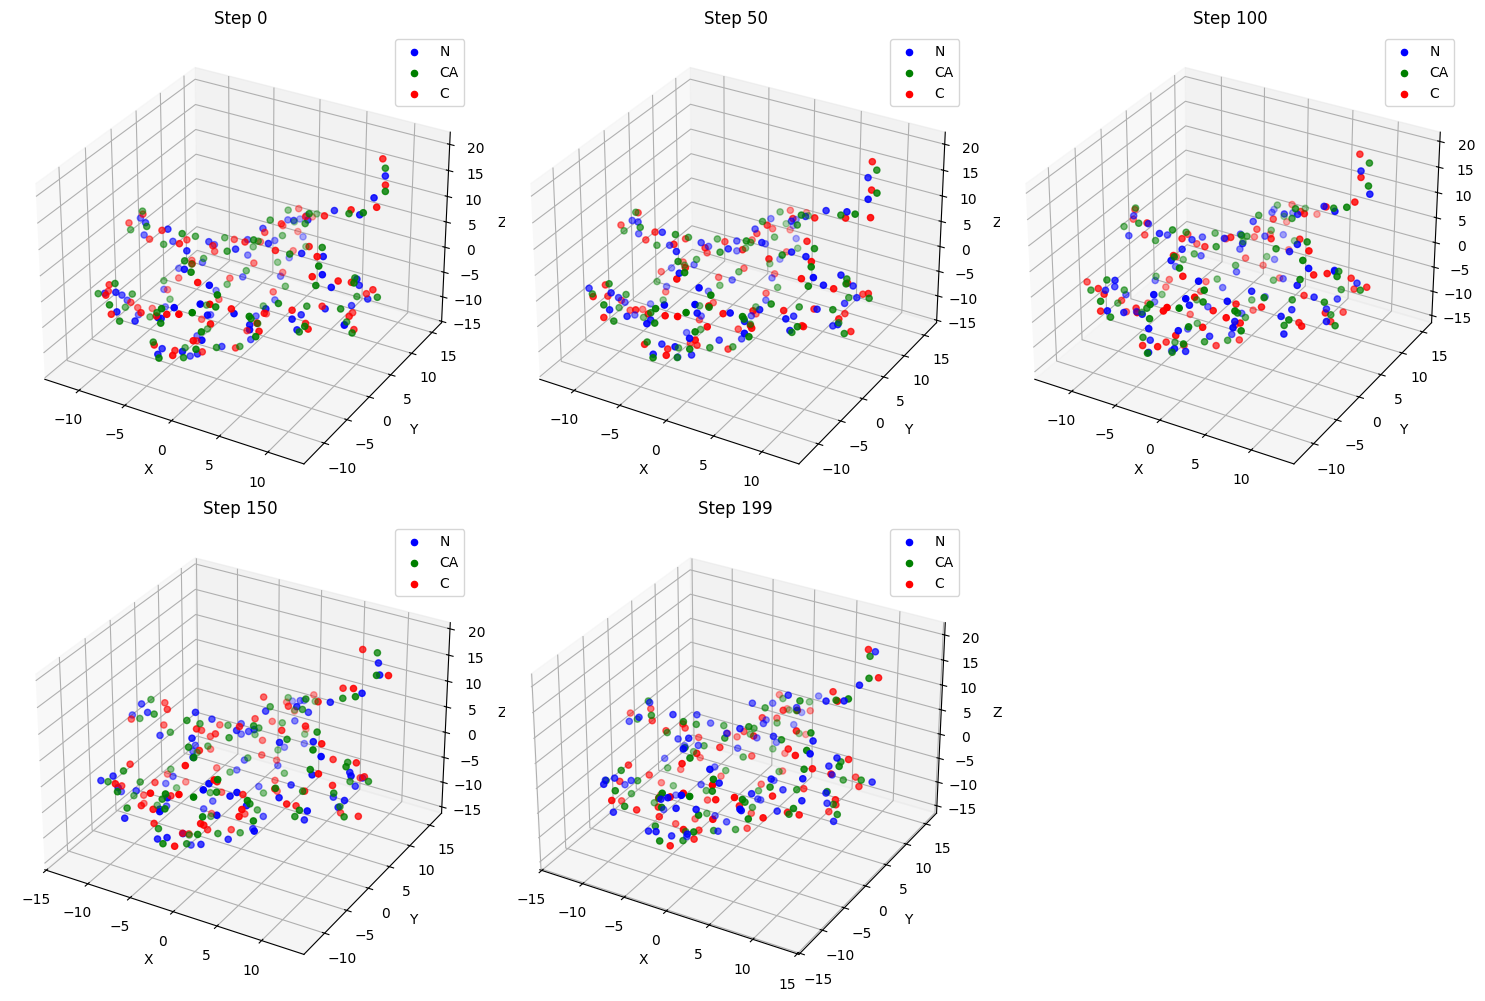

In [15]:
#Now visualize the rotation diffusion
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Set up subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(5 * cols, 5 * rows))

for i, step_index in enumerate(step_indexes):
    coords = diffused_frame_crds[:, step_index, :, :]  # shape: [res_num, 3, 3]
    
    N_coords = coords[:, 0, :]   # N atoms
    CA_coords = coords[:, 1, :]  # CA atoms
    C_coords = coords[:, 2, :]   # C atoms
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    ax.scatter(N_coords[:, 0], N_coords[:, 1], N_coords[:, 2], color='blue', label='N', s=20)
    ax.scatter(CA_coords[:, 0], CA_coords[:, 1], CA_coords[:, 2], color='green', label='CA', s=20)
    ax.scatter(C_coords[:, 0], C_coords[:, 1], C_coords[:, 2], color='red', label='C', s=20)
    
    ax.set_title(f"Step {step_index}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()

plt.tight_layout()
plt.show()


### Questions

I am quite confused by the translation_diffuser as I thought N, CA, C within the same residue will diffuse togethere. But it is obviously not the case. Based on the code, this shouldn't happen.

### trouble shoot:

It turns out to be the scaling issue of the axis.  After printing out the average NCA CAC bond lengthes, we know that rigid frame among CA N C is perserved. 

After fixing the sacles of axises, it makes sense now.

In [17]:
# Now combine the translation and rotation
# As protein is kinda seen as point cloud, translation and rotaion is independent 
# Due to Wigner nature (diffusion  Wt-Ws = (sigma(t)^2-sigma(s)^2)*e ~N(0, Id)), we could can compute diffused 
#coordinates at any time without simulating adding noise process.


# method 1: used in rfdiffusion 
cum_delta = deltas.cumsum(dim=1) # cum_delta is noise for each step  [L, n, 3] -> [L,n,3]
        # The coordinates of the translated AND rotated frames
diffused_BB = (
    torch.from_numpy(diffused_frame_crds) + cum_delta[:, :, None, :] # [L,n,]
).transpose(0, 1)  # [n,L,3,3]

# method 2: I think it is more computationally efficient
diffused_BB2 = (
    torch.from_numpy(diffused_frame_crds) + diffused_T -xyz[:,None,:,:] # [L,n,]
).transpose(0, 1)  # [n,L,3,3]
        # diffused_BB  = torch.from_numpy(diffused_frame_crds).transpose(0,1)

# They are equally applicable.
is_close = torch.allclose(diffused_BB, diffused_BB2, atol=1e-5, rtol=1e-5)
print("Tensors are almost equal:", is_close)
#print('They are the same!')


Tensors are almost equal: True


NCA avg: 1.4733696107286516 std: 0.01694893793400944
CAC  avg: 1.5215819483790822 std: 0.015672407821294417
NCA avg: 1.4733696107286516 std: 0.016948937934009374
CAC  avg: 1.5215819483790822 std: 0.01567240782129437
NCA avg: 1.4733696107286516 std: 0.016948937934009378
CAC  avg: 1.5215819483790824 std: 0.015672407821294383
NCA avg: 1.4733696107286516 std: 0.01694893793400948
CAC  avg: 1.5215819483790824 std: 0.015672407821294317
NCA avg: 1.4733696107286516 std: 0.016948937934009416
CAC  avg: 1.5215819483790824 std: 0.015672407821294344


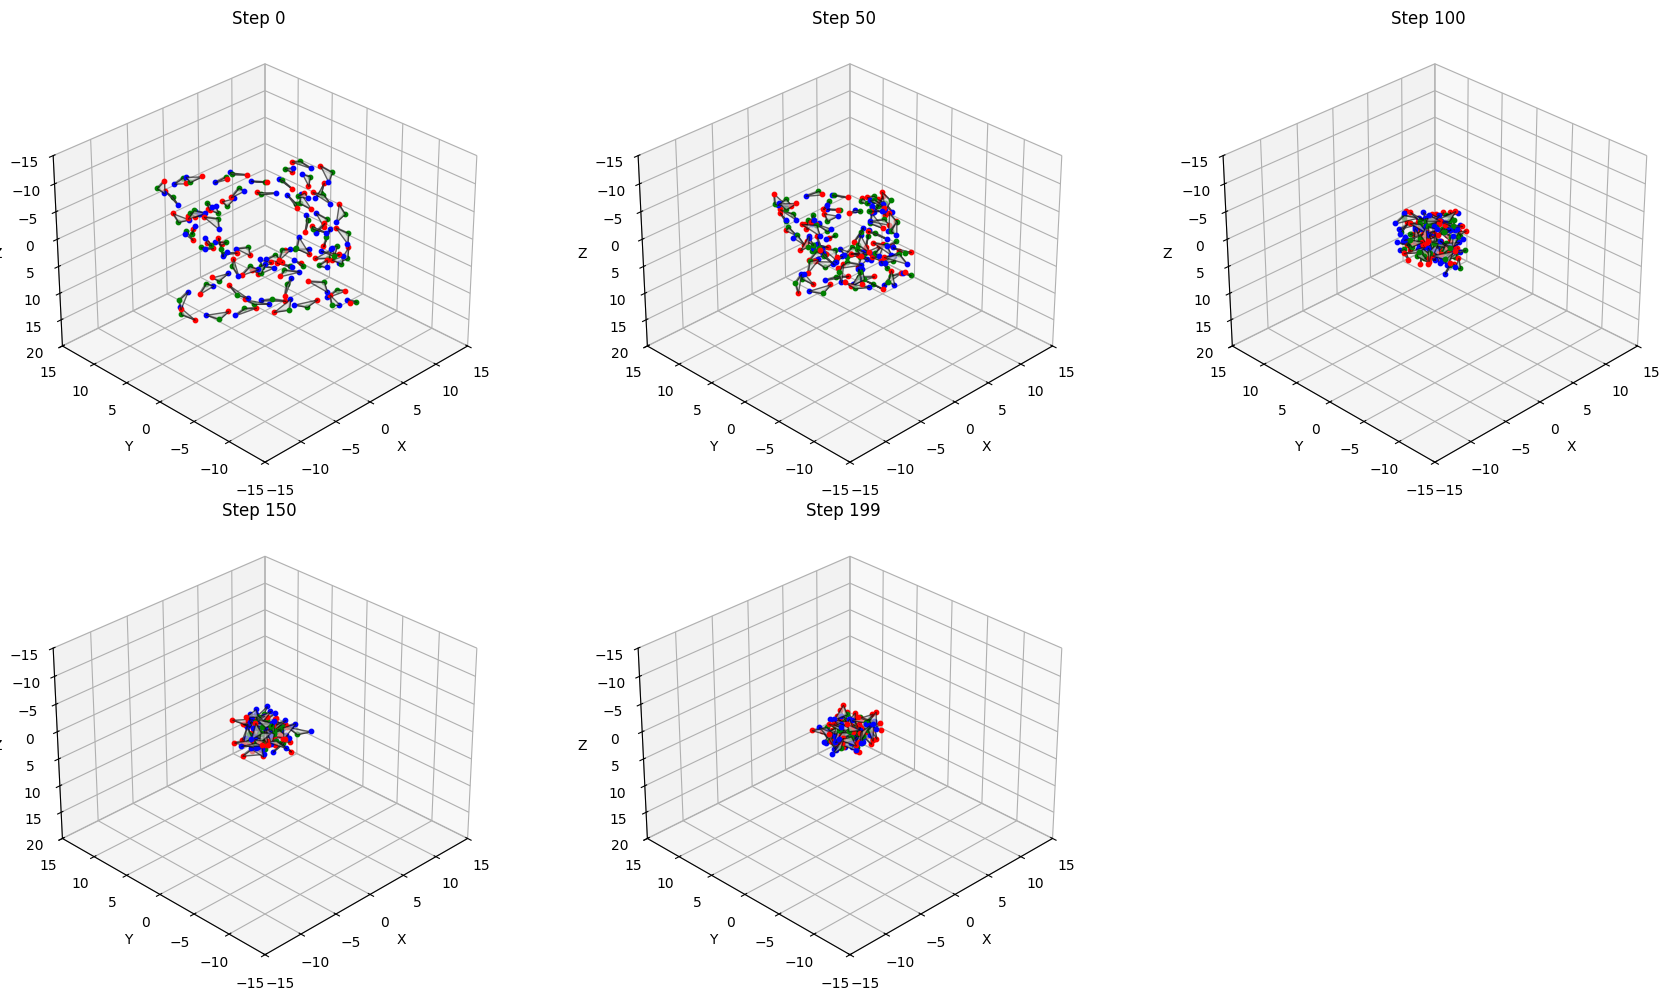

In [17]:
# visualize the final diffused protein with both rotation and translation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))



for i, step_index in enumerate(step_indexes):
    coords = diffused_BB.transpose(0,1)[:, step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = diffused_BB.shape[1]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


In [18]:
trans_test.beta_schedule.shape
test.discrete_sigma.shape


(500,)

# Step II. the reverse SDE

we know the noise scheduler:

translation: trans_test.bete_schedule, trans_test.alpha_schedule, tran_test.alphabar_shedeule  # [200,]
rotation: test.sigma(t) t ~range(0,200,200)/200 


for the translation diffusion  p(xt-1|xt)= 


for the rotation diffusion part, reserve SDE is used:



In [12]:

from abc import ABC, abstractmethod
from typing import Optional
import math

class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [28]:
class EulerMaruyama(Simulator):
    def __init__(self, diffuser):
        """
        Args:
            - beta_schedule: beta schedule, shape (num_timesteps,)
            - sigma_schedule: sigma schedule, shape (num_timesteps,)
            - noise_type: type of noise to add, either "linear" or "log"
        """
        super().__init__()
        self.diffuser = diffuser

    def step(self, xt: torch.Tensor, x0:torch.tensor, ts: torch.Tensor, ):
        """
        Takes one simulation step
        Args:
            - zt: state at time t, shape (batch_size, num_residues, 3, 3)
            - ts: time , shape () [1,...,T]
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - nxt: reverse to xt-1
        """
        # Get the beta and sigma values for the current timestep
        beta_t = self.diffuser.beta_schedule[ts]
        alpha_bar_t = self.diffuser.alphabar_schedule[ts]
        alpha_bar_t_minus_1 = self.diffuser.alphabar_schedule[ts -1]
        coeff1 = (alpha_bar_t_minus_1**0.5 * beta_t) / (1 - alpha_bar_t)
        coeff2 = (alpha_bar_t**0.5 * (1 - alpha_bar_t_minus_1)) / (1 - alpha_bar_t)
        z_t = xt[:,:,1,:]  # Extract the z_t component
        z0_hat = x0[:,:,1,:]
        mean_z = coeff1 * z0_hat + coeff2 * z_t
        std_z = (beta_t**0.5) * torch.ones_like(z_t)
        z_t_minus_1 = mean_z + std_z * torch.randn_like(z_t)
        diff = z_t_minus_1 - z_t
        x_t_minus_1 = xt + diff[:,:,None,:]

        return x_t_minus_1
    
    def simulate_with_trajectory(self, x: torch.Tensor, x0: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            x = self.step(x, x0, t)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [84]:
print(diffused_BB.shape)
print(diffused_T.shape)

torch.Size([200, 76, 3, 3])
torch.Size([76, 200, 3, 3])


In [86]:
# test EulerMaruyama simulatior
from tqdm import tqdm

test_simulator = EulerMaruyama(diffuser=trans_test)

#test_simulator.diffuser.beta_schedule.shape
ts=descending_range = range(199, -1, -1)
#results=test_simulator.simulate_with_trajectory(diffused_BB[None,199,:,:,:], diffused_BB[None,0,:,:,:], ts)

results=test_simulator.simulate_with_trajectory(diffused_T.transpose(0,1)[None,199,:,:,:], diffused_T.transpose(0,1)[None,0,:,:,:], ts)


100%|██████████| 199/199 [00:00<00:00, 9023.81it/s]


torch.Size([1, 200, 76, 3, 3])
NCA avg: 1.4733696107286514 std: 0.016948937934009464
CAC  avg: 1.521581948379082 std: 0.015672407821294407
NCA avg: 1.4733696107286514 std: 0.016948937934009502
CAC  avg: 1.5215819483790818 std: 0.015672407821294514
NCA avg: 1.4733696107286514 std: 0.016948937934009492
CAC  avg: 1.5215819483790818 std: 0.015672407821294514
NCA avg: 1.4733696107286516 std: 0.016948937934009457
CAC  avg: 1.5215819483790818 std: 0.015672407821294525
NCA avg: 1.4733696107286516 std: 0.016948937934009436
CAC  avg: 1.5215819483790818 std: 0.01567240782129454


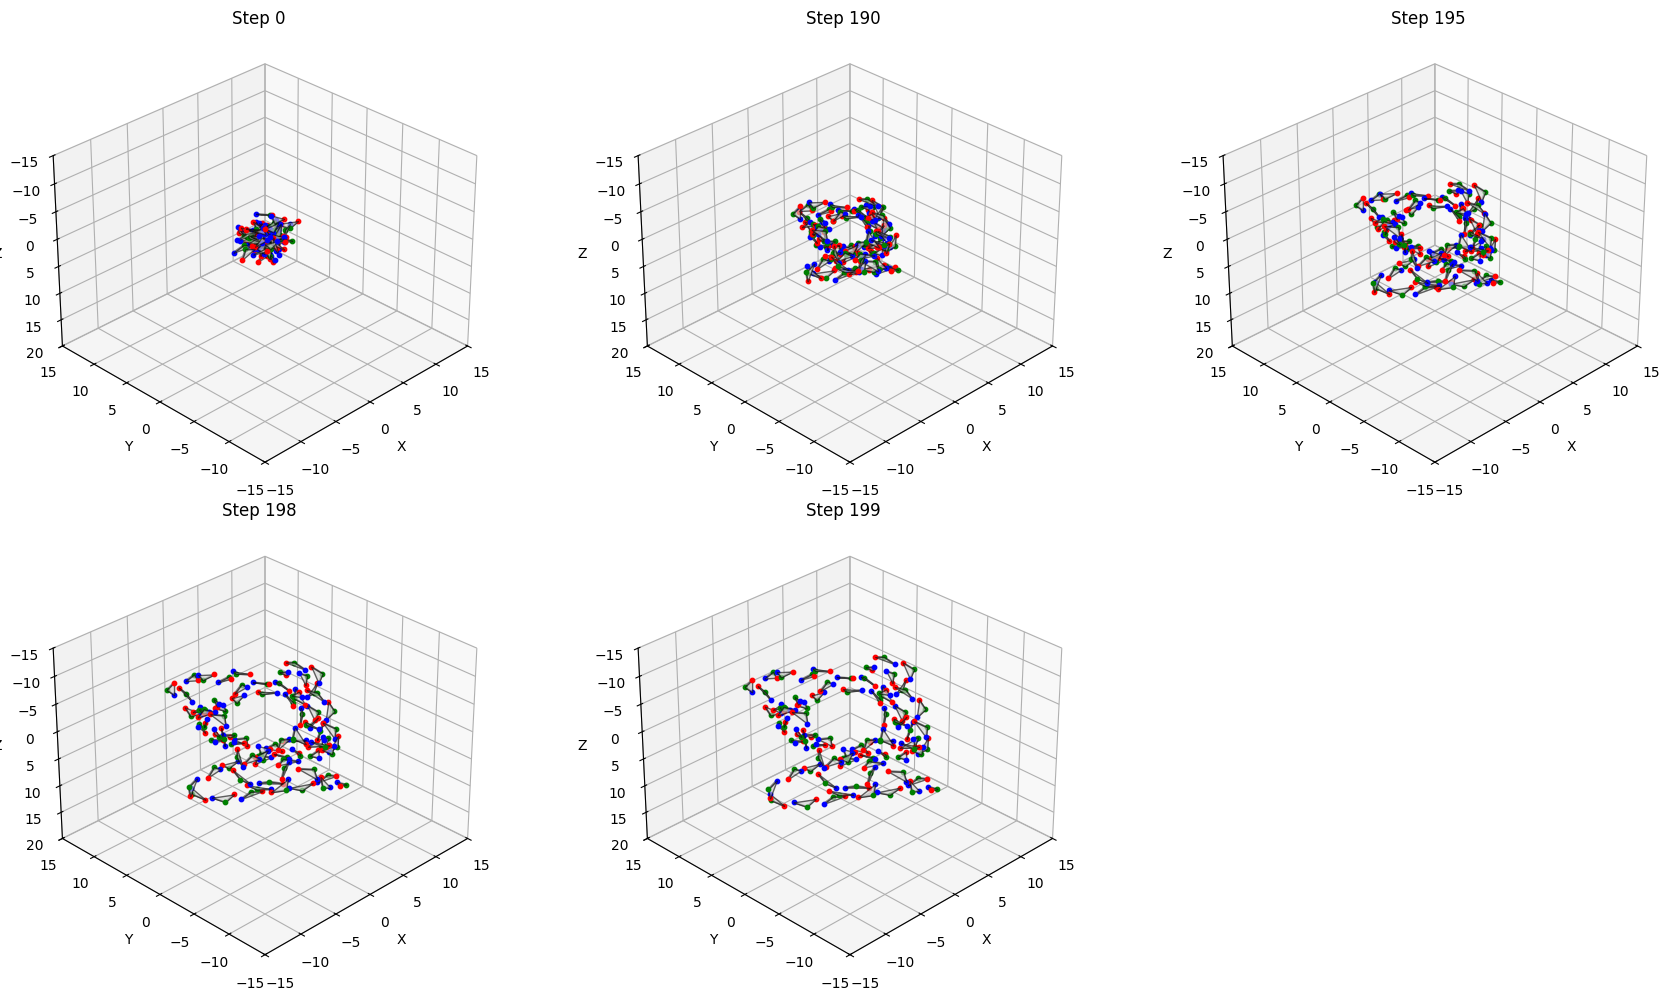

In [87]:
print(results.shape)
# visualize the final diffused protein with both rotation and translation

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Step indexes you want to visualize
step_indexes = [0, 190, 195, 198, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))

res_adj = results.squeeze(0).transpose(0,1)  # Remove the batch dimension
# res shape: [n, L, 3, 3]
for i, step_index in enumerate(step_indexes):
    coords = res_adj[ :,step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = res_adj.shape[0]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


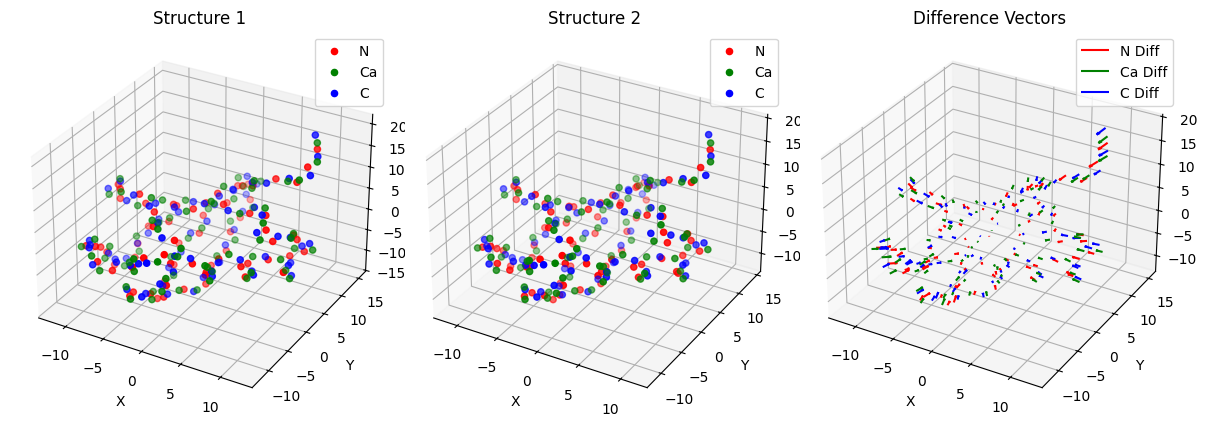

In [88]:
# let me see the difference between the ground truth and the simulated structure
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_structures(structure1: torch.Tensor, structure2: torch.Tensor, title1="Structure 1", title2="Structure 2"):
    """
    Plots two 3D structures and their differences.

    Args:
        structure1 (torch.Tensor): First structure with shape [num_res, 3, 3].
        structure2 (torch.Tensor): Second structure with shape [num_res, 3, 3].
        title1 (str): Title for the first structure.
        title2 (str): Title for the second structure.
    """
    assert structure1.shape == structure2.shape, "Structures must have the same shape"

    # Convert tensors to numpy for plotting
    structure1 = structure1.numpy()
    structure2 = structure2.numpy()

    # Extract atom types: N, Ca, C
    atom_types = ["N", "Ca", "C"]
    colors = ["r", "g", "b"]  # Colors for each atom type

    # Compute the difference
    diff = structure2 - structure1
    diff_norm = torch.norm(torch.tensor(diff), dim=2)

    fig = plt.figure(figsize=(12, 6))

    # Plot Structure 1
    ax1 = fig.add_subplot(131, projection='3d')
    for i, atom in enumerate(atom_types):
        ax1.scatter(structure1[:, i, 0], structure1[:, i, 1], structure1[:, i, 2], c=colors[i], label=atom)
    ax1.set_title(title1)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.legend()

    # Plot Structure 2
    ax2 = fig.add_subplot(132, projection='3d')
    for i, atom in enumerate(atom_types):
        ax2.scatter(structure2[:, i, 0], structure2[:, i, 1], structure2[:, i, 2], c=colors[i], label=atom)
    ax2.set_title(title2)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
    ax2.legend()

    # Plot Difference
    ax3 = fig.add_subplot(133, projection='3d')
    for i, atom in enumerate(atom_types):
        ax3.quiver(
            structure1[:, i, 0], structure1[:, i, 1], structure1[:, i, 2],  # Start points
            diff[:, i, 0], diff[:, i, 1], diff[:, i, 2],  # Vector components
            color=colors[i], label=f"{atom} Diff"
        )
    ax3.set_title("Difference Vectors")
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z")
    ax3.legend()

    plt.tight_layout()
    plt.show()


structure1 = diffused_BB[0,:,:,:]
structure2 = res_adj.transpose(0,1)[199,:,:,:] # Structure 2 with small random differences

# Plot the structures
plot_structures(structure1, structure2)


In [ ]:
#test.reverse_sample_vectorized( R_t, R_0, t, noise_level,)

In [96]:
# Now we reverse the rotation
from scipy.spatial.transform import Rotation as scipy_R
class RotEulerMaruyama(Simulator):
    def __init__(self, diffuser):
        """
        Args:
            - beta_schedule: beta schedule, shape (num_timesteps,)
            - sigma_schedule: sigma schedule, shape (num_timesteps,)
            - noise_type: type of noise to add, either "linear" or "log"
        """
        super().__init__()
        self.diffuser = diffuser

    def step(self, rt: torch.Tensor, r0:torch.tensor, ts: torch.Tensor,noise_level=0.5):
        """
        Takes one simulation step
        Args:
            - rt: state at time t, shape (batch_size, num_residues, 3, 3)
            - ts: time , shape () [1,...,T]
            - r0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - r_t_minus_1: reverse to rt-1
        """
        # Get the beta and sigma values for the current timestep
        r_t_minus_1=self.diffuser.reverse_sample_vectorized(rt, r0, ts, noise_level)

        return r_t_minus_1
    
    def simulate_with_trajectory(self, x: torch.Tensor, x0: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, num_res,3,3)
            - ts: timesteps, shape (num_timesteps,)
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        r, Ca, xyz = extract_r_z(x.squeeze(0))
        r0, _, _ = extract_r_z(x0.squeeze(0))
          # this must be to normalize them or something
        r0 = scipy_R.from_matrix(r0.squeeze().numpy()).as_matrix()
        r = scipy_R.from_matrix(r.squeeze().numpy()).as_matrix()
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            r = self.step(r, r0, t)   # [num, 3, 3] update rotation matrix
            # update the structure
            x = (np.einsum( "nij,naj->nai", r, xyz[:, :3, :] - Ca[:, None, ...].numpy())
            + Ca[:, None,  :].numpy())

        # Convert to PyTorch tensor and apply unsqueeze
            x = torch.from_numpy(x).unsqueeze(0)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)






In [90]:
print(diffused_frame_crds.shape)
print(diffused_BB.shape)
torch.tensor(diffused_frame_crds).transpose(0,1).shape


(76, 200, 3, 3)
torch.Size([200, 76, 3, 3])


torch.Size([200, 76, 3, 3])

In [97]:


test_rot_simulator = RotEulerMaruyama(diffuser=test)
ts=descending_range = range(199, -1, -1)
x_init = torch.tensor(diffused_frame_crds).transpose(0,1)[199,:,:,:].unsqueeze(0)
x0 = torch.tensor(diffused_frame_crds).transpose(0,1)[0,:,:,:].unsqueeze(0)

results_rot=test_rot_simulator.simulate_with_trajectory(x_init,x0, ts)

100%|██████████| 199/199 [00:00<00:00, 1747.68it/s]


torch.Size([1, 200, 76, 3, 3])
NCA avg: 1.4733696107286516 std: 0.01694893793400941
CAC  avg: 1.5215819483790824 std: 0.01567240782129443
NCA avg: 1.4733696107286514 std: 0.016948937934009273
CAC  avg: 1.5215819483790824 std: 0.01567240782129432
NCA avg: 1.4733696107286516 std: 0.016948937934009114
CAC  avg: 1.5215819483790824 std: 0.01567240782129425
NCA avg: 1.4733696107286511 std: 0.016948937934009256
CAC  avg: 1.5215819483790822 std: 0.015672407821294147
NCA avg: 1.4733696107286516 std: 0.01694893793400915
CAC  avg: 1.5215819483790824 std: 0.01567240782129407


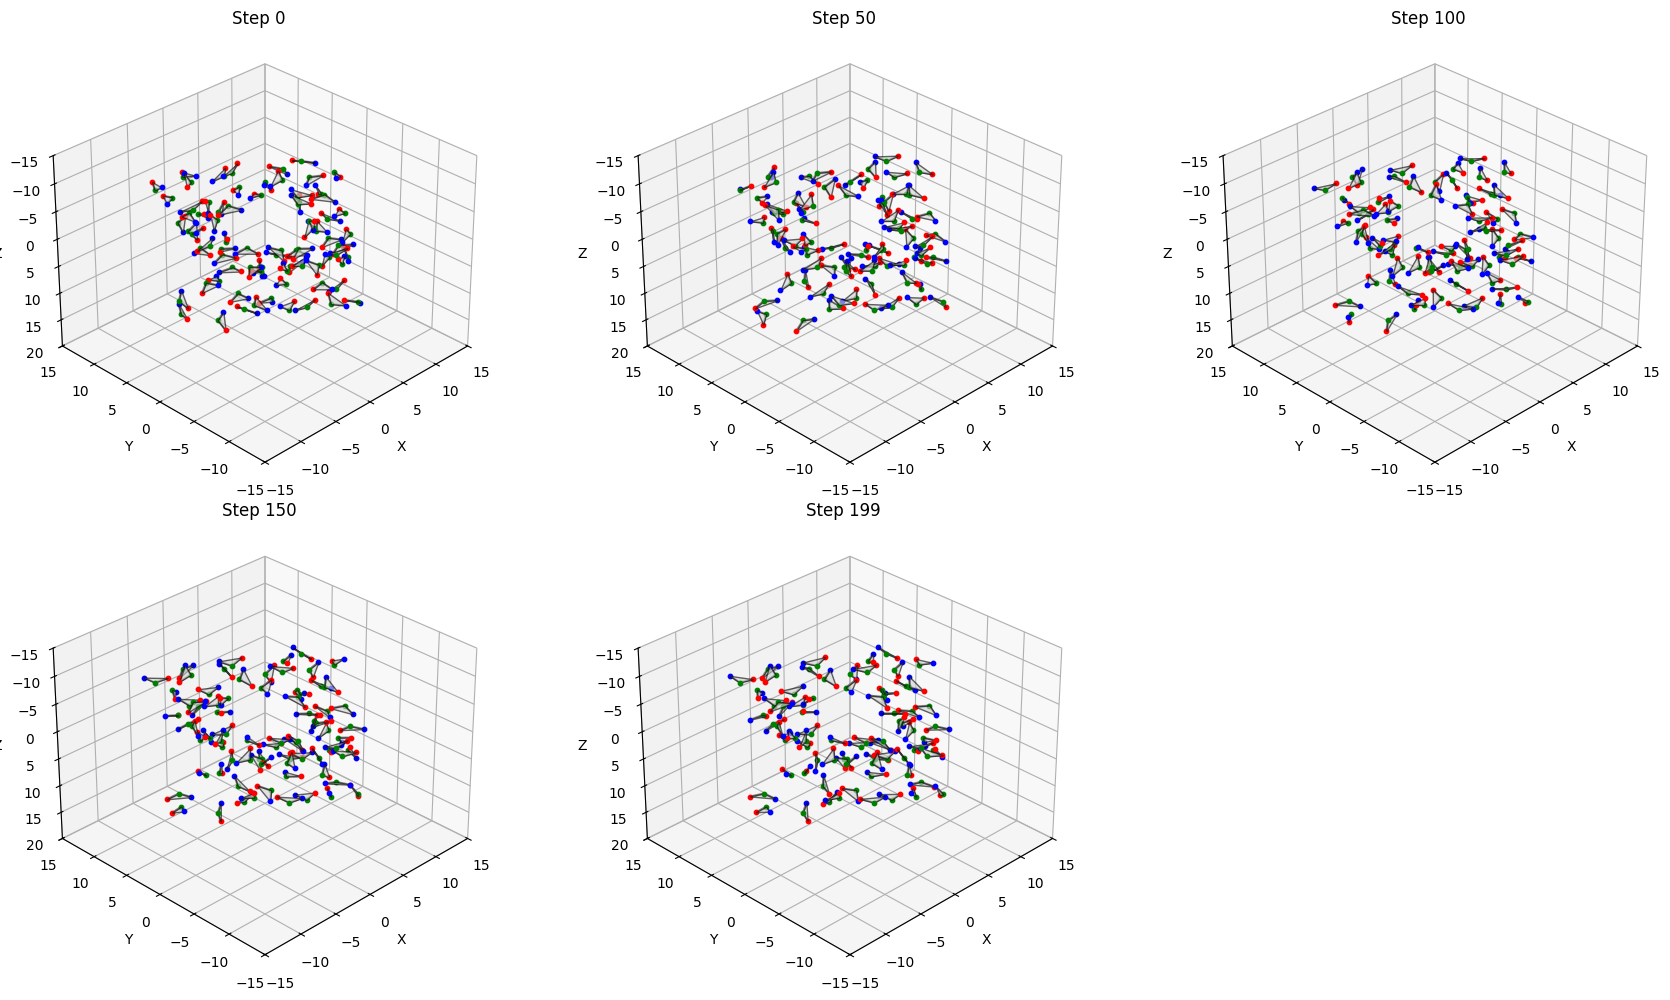

In [98]:
print(results_rot.shape)
# visualize the final diffused protein with both rotation and translation


# Step indexes you want to visualize
step_indexes = [0, 50, 100, 150, 199]  # You can change this

# Setup subplots
n_steps = len(step_indexes)
cols = min(n_steps, 3)
rows = (n_steps + cols - 1) // cols

fig = plt.figure(figsize=(6 * cols, 5 * rows))

res_rot_adj = results_rot.squeeze(0).transpose(0,1)  # Remove the batch dimension
# res shape: [n, L, 3, 3]
for i, step_index in enumerate(step_indexes):
    coords = res_rot_adj[ :,step_index, :, :]  # shape: [res_num, 3, 3]

    res_num = res_rot_adj.shape[0]
    
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    
    for res in range(res_num):
        n = coords[res, 0]
        ca = coords[res, 1]
        c = coords[res, 2]
        
        #FIX: Convert points to list
        triangle = [n.tolist(), ca.tolist(), c.tolist()]
        poly = Poly3DCollection([triangle], alpha=0.6)
        poly.set_facecolor('lightgray')
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)
        ax.plot(*zip(n, ca), color='gray')
        ax.plot(*zip(ca, c), color='gray')
        
        ax.scatter(*n, color='blue', s=10)
        ax.scatter(*ca, color='green', s=10)
        ax.scatter(*c, color='red', s=10)

    n_ca_dists = np.linalg.norm(coords[:, 0] - coords[:, 1], axis=-1)
    ca_c_dists = np.linalg.norm(coords[:, 1] - coords[:, 2], axis=-1)

    print("NCA avg:", np.mean(n_ca_dists), "std:", np.std(n_ca_dists))
    print("CAC  avg:", np.mean(ca_c_dists), "std:", np.std(ca_c_dists))


    ax.set_title(f"Step {step_index}")
    ax.set_xlim([15, -15])
    ax.set_ylim([15, -15])
    ax.set_zlim([20, -15])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

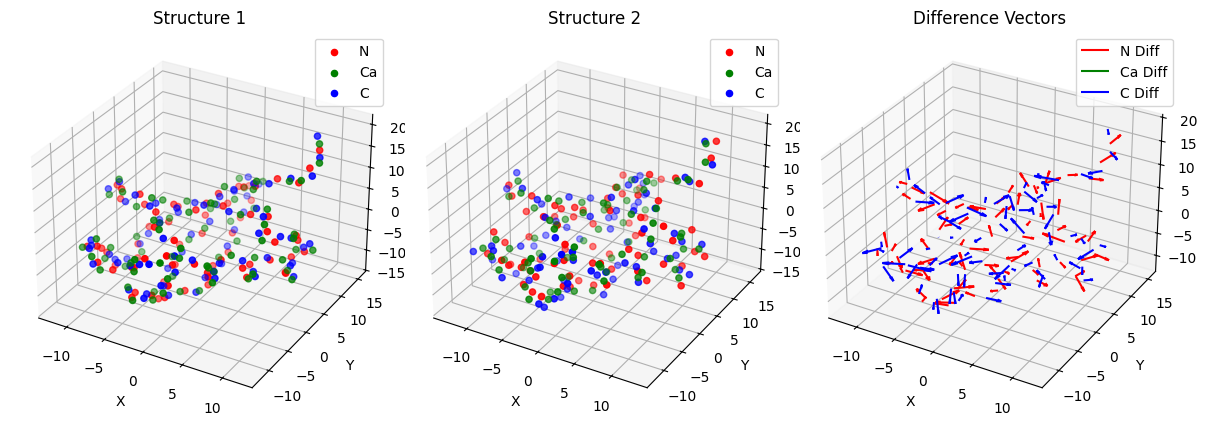

In [99]:
# examine the difference between the ground truth and the simulated structure
structure1 = torch.tensor(diffused_frame_crds[:,0,:,:])
structure2 = res_rot_adj.transpose(0,1)[199,:,:,:] # Structure 2 with small random differences

# Plot the structures
plot_structures(structure1, structure2)

# Problems

I don't know why I cann't reverse the rotation diffusion. 

I compare my code to the orginal RFdiffusion code; I didn't spot a cause.